Import danych

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import meanabs,mse,rmse,rmspe,stde

# Wczytanie danych z pliku CSV
data = pd.read_csv('data_csv.csv', sep=';')

# Wybór kolumn, które będą wykorzystywane do prognozowania cen prądu
selected_features = ['Zachmurzenie', 'Prędkość wiatru', 'Temperatura powietrza', 'Opad', 'Zdolności produkcyjne', 'Zapotrzebowanie', 'Generacja źródeł wiatrowych', 'Generacja źródeł fotowoltaicznych']

# Wybór kolumny z cenami prądu jako target
target_column = 'Ceny energii'

# Tworzenie folderu dla wyników
result_folder = 'wyniki_LSTM'
os.makedirs(result_folder, exist_ok=True)

# Przygotowanie danych egzogenicznych i cen prądu
X = data[selected_features].values
y = data[target_column].values

# Normalizacja danych
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Podział danych na zbiór treningowy i testowy
num_test_samples = int(0.2*(len(X)))
X_train = X_scaled[:-num_test_samples]
y_train = y_scaled[:-num_test_samples]
X_test = X_scaled[-num_test_samples:]
y_test = y_scaled[-num_test_samples:]


In [2]:
X

array([[1.06896552e+00, 5.00000000e+00, 1.15896552e+01, ...,
        1.32720000e+04, 5.70200000e+03, 0.00000000e+00],
       [9.31034483e-01, 5.31034483e+00, 1.19034483e+01, ...,
        1.25670000e+04, 4.77000000e+03, 0.00000000e+00],
       [9.48275862e-01, 5.44827586e+00, 1.20482759e+01, ...,
        1.23760000e+04, 3.15600000e+03, 0.00000000e+00],
       ...,
       [2.06896552e-01, 1.91379310e+00, 1.25172414e+01, ...,
        1.97740000e+04, 1.18500000e+03, 0.00000000e+00],
       [2.41379310e-01, 1.91379310e+00, 1.14913793e+01, ...,
        1.80880000e+04, 1.49900000e+03, 0.00000000e+00],
       [2.75862069e-01, 1.84482759e+00, 1.05155172e+01, ...,
        1.64150000e+04, 1.63400000e+03, 0.00000000e+00]])

Tworzenie modelu LSTM

In [20]:
# Przygotowanie danych w formie sekwencji dla modelu LSTM
time_steps = 24                  # z iu bierze do prognozy

liczb_neuronow = 516
l_epok = 100                    # ile iteracji modelu
l_obser= 64                     # jako batch size
optymalizator = 'adam'          # rodzaj optymalizacji modelu 
rodz_aktywacji = 'tanh'         # rodzaj aktywacji LSTM       

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps+1):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps-1])  # Używamy ostatniej wartości z sekwencji jako target
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)


# Utworzenie modelu LSTM
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=liczb_neuronow, input_shape=(time_steps, X_train_seq.shape[2]), activation=rodz_aktywacji, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation=rodz_aktywacji, return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation=rodz_aktywacji, return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation=rodz_aktywacji))
model.add(tf.keras.layers.Dense(1))
# model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=optymalizator, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

# Trening modelu
model_tworz = model.fit(X_train_seq, y_train_seq, epochs=l_epok, batch_size=l_obser, validation_split=0.2)

# Prognozowanie na zbiorze testowym
predictions = model.predict(X_test_seq)

# Skalowanie spowrotem do pierwotnej skali
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

Epoch 1/100
36/36 [==============================] - 14s 206ms/step - loss: 0.0356 - mean_absolute_percentage_error: 28.2645 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 28.7091
Epoch 2/100
36/36 [==============================] - 6s 162ms/step - loss: 0.0150 - mean_absolute_percentage_error: 20.2908 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 29.3169
Epoch 3/100
36/36 [==============================] - 6s 163ms/step - loss: 0.0118 - mean_absolute_percentage_error: 17.8727 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 28.0239
Epoch 4/100
36/36 [==============================] - 6s 160ms/step - loss: 0.0112 - mean_absolute_percentage_error: 17.2302 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 28.1349
Epoch 5/100
36/36 [==============================] - 6s 162ms/step - loss: 0.0097 - mean_absolute_percentage_error: 16.0923 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 23.8155
Epoch 6/100
36/36 [==============================] - 6

In [22]:

mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
mape_metric.update_state(y_test_rescaled, predictions_rescaled)
mape_result = mape_metric.result().numpy()
errormeanabs = meanabs(y_test_rescaled, predictions_rescaled)
errormse = mse(y_test_rescaled, predictions_rescaled)
errorrmse = rmse(y_test_rescaled, predictions_rescaled)
errorrmspe = rmspe(y_test_rescaled, predictions_rescaled)
errorstde = stde(y_test_rescaled, predictions_rescaled)
results = {
    'Metric': ['Mean Absolute', 'MSE', 'RMSE', 'Root Mean Squared Percentage RMSPE', 'STDE'],
    'Value': [errormeanabs, errormse, errorrmse, errorrmspe, errorstde]}

print(results)

{'Metric': ['Mean Absolute', 'MSE', 'RMSE', 'Root Mean Squared Percentage RMSPE', 'STDE'], 'Value': [array([56.77546363]), array([6417.8089875]), array([80.11122885]), array([8.04959072]), array([80.07183744])]}


Miary błędu predykcji

(0.0, 100.0)

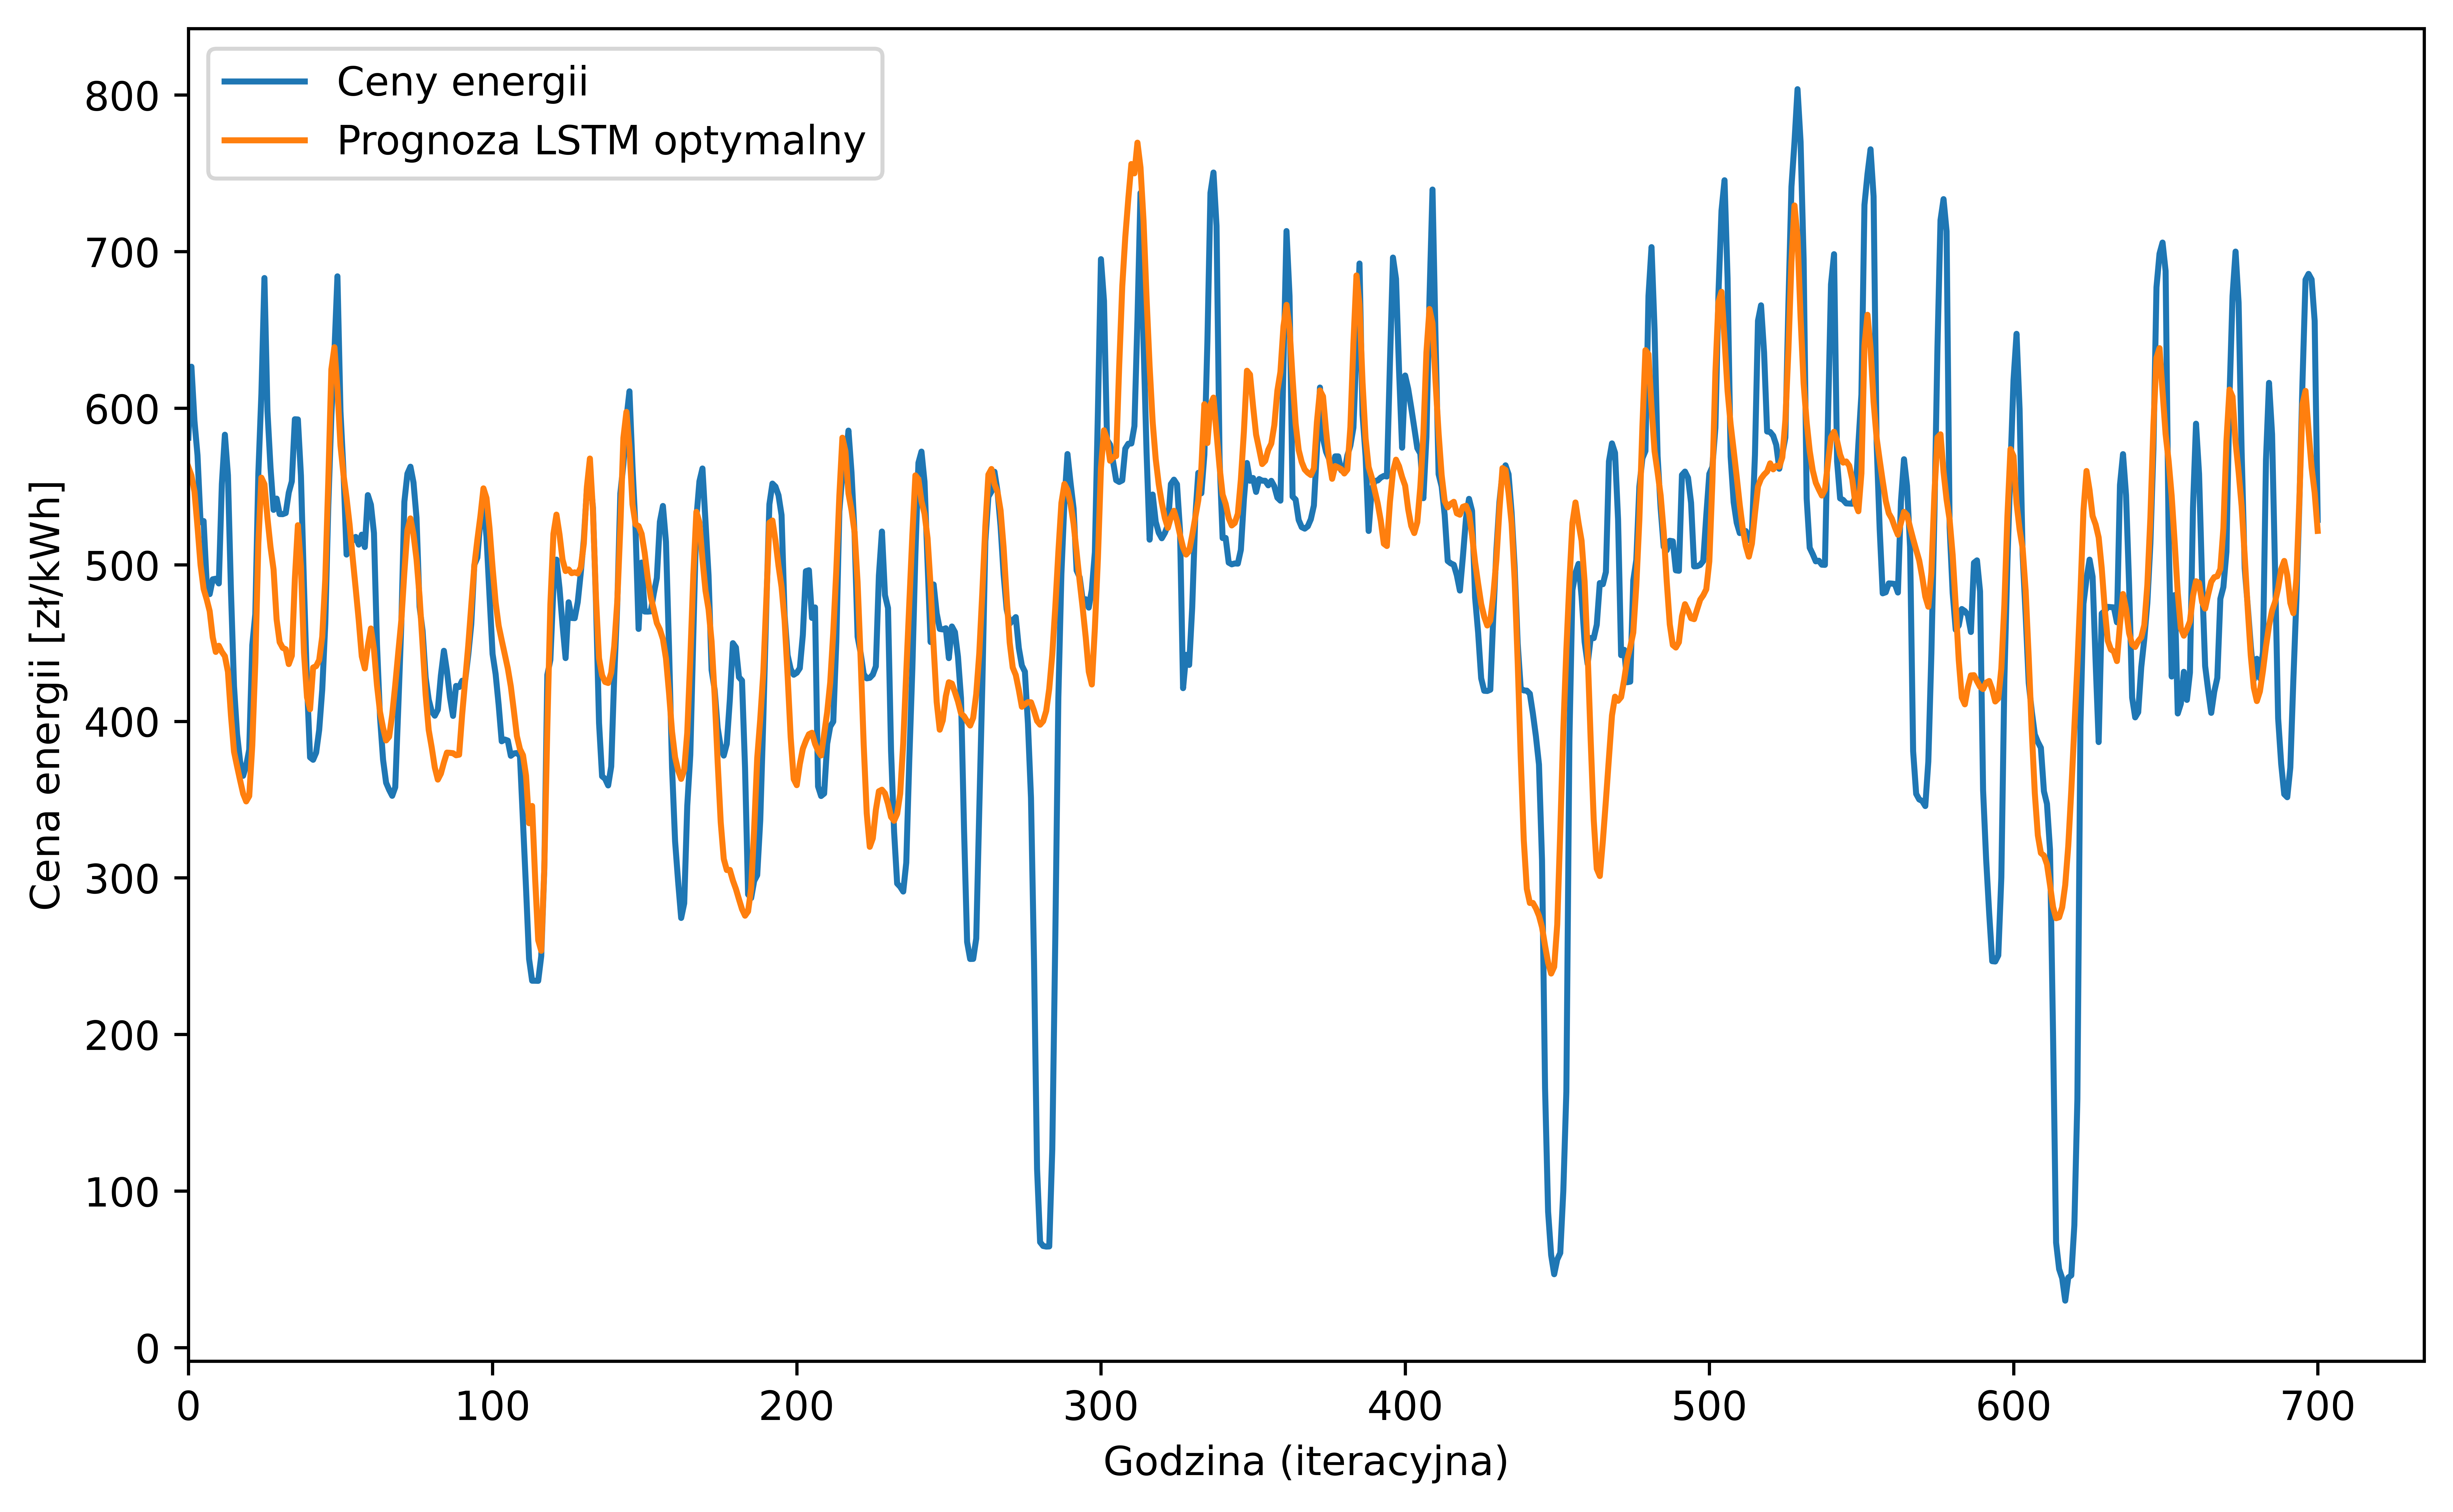

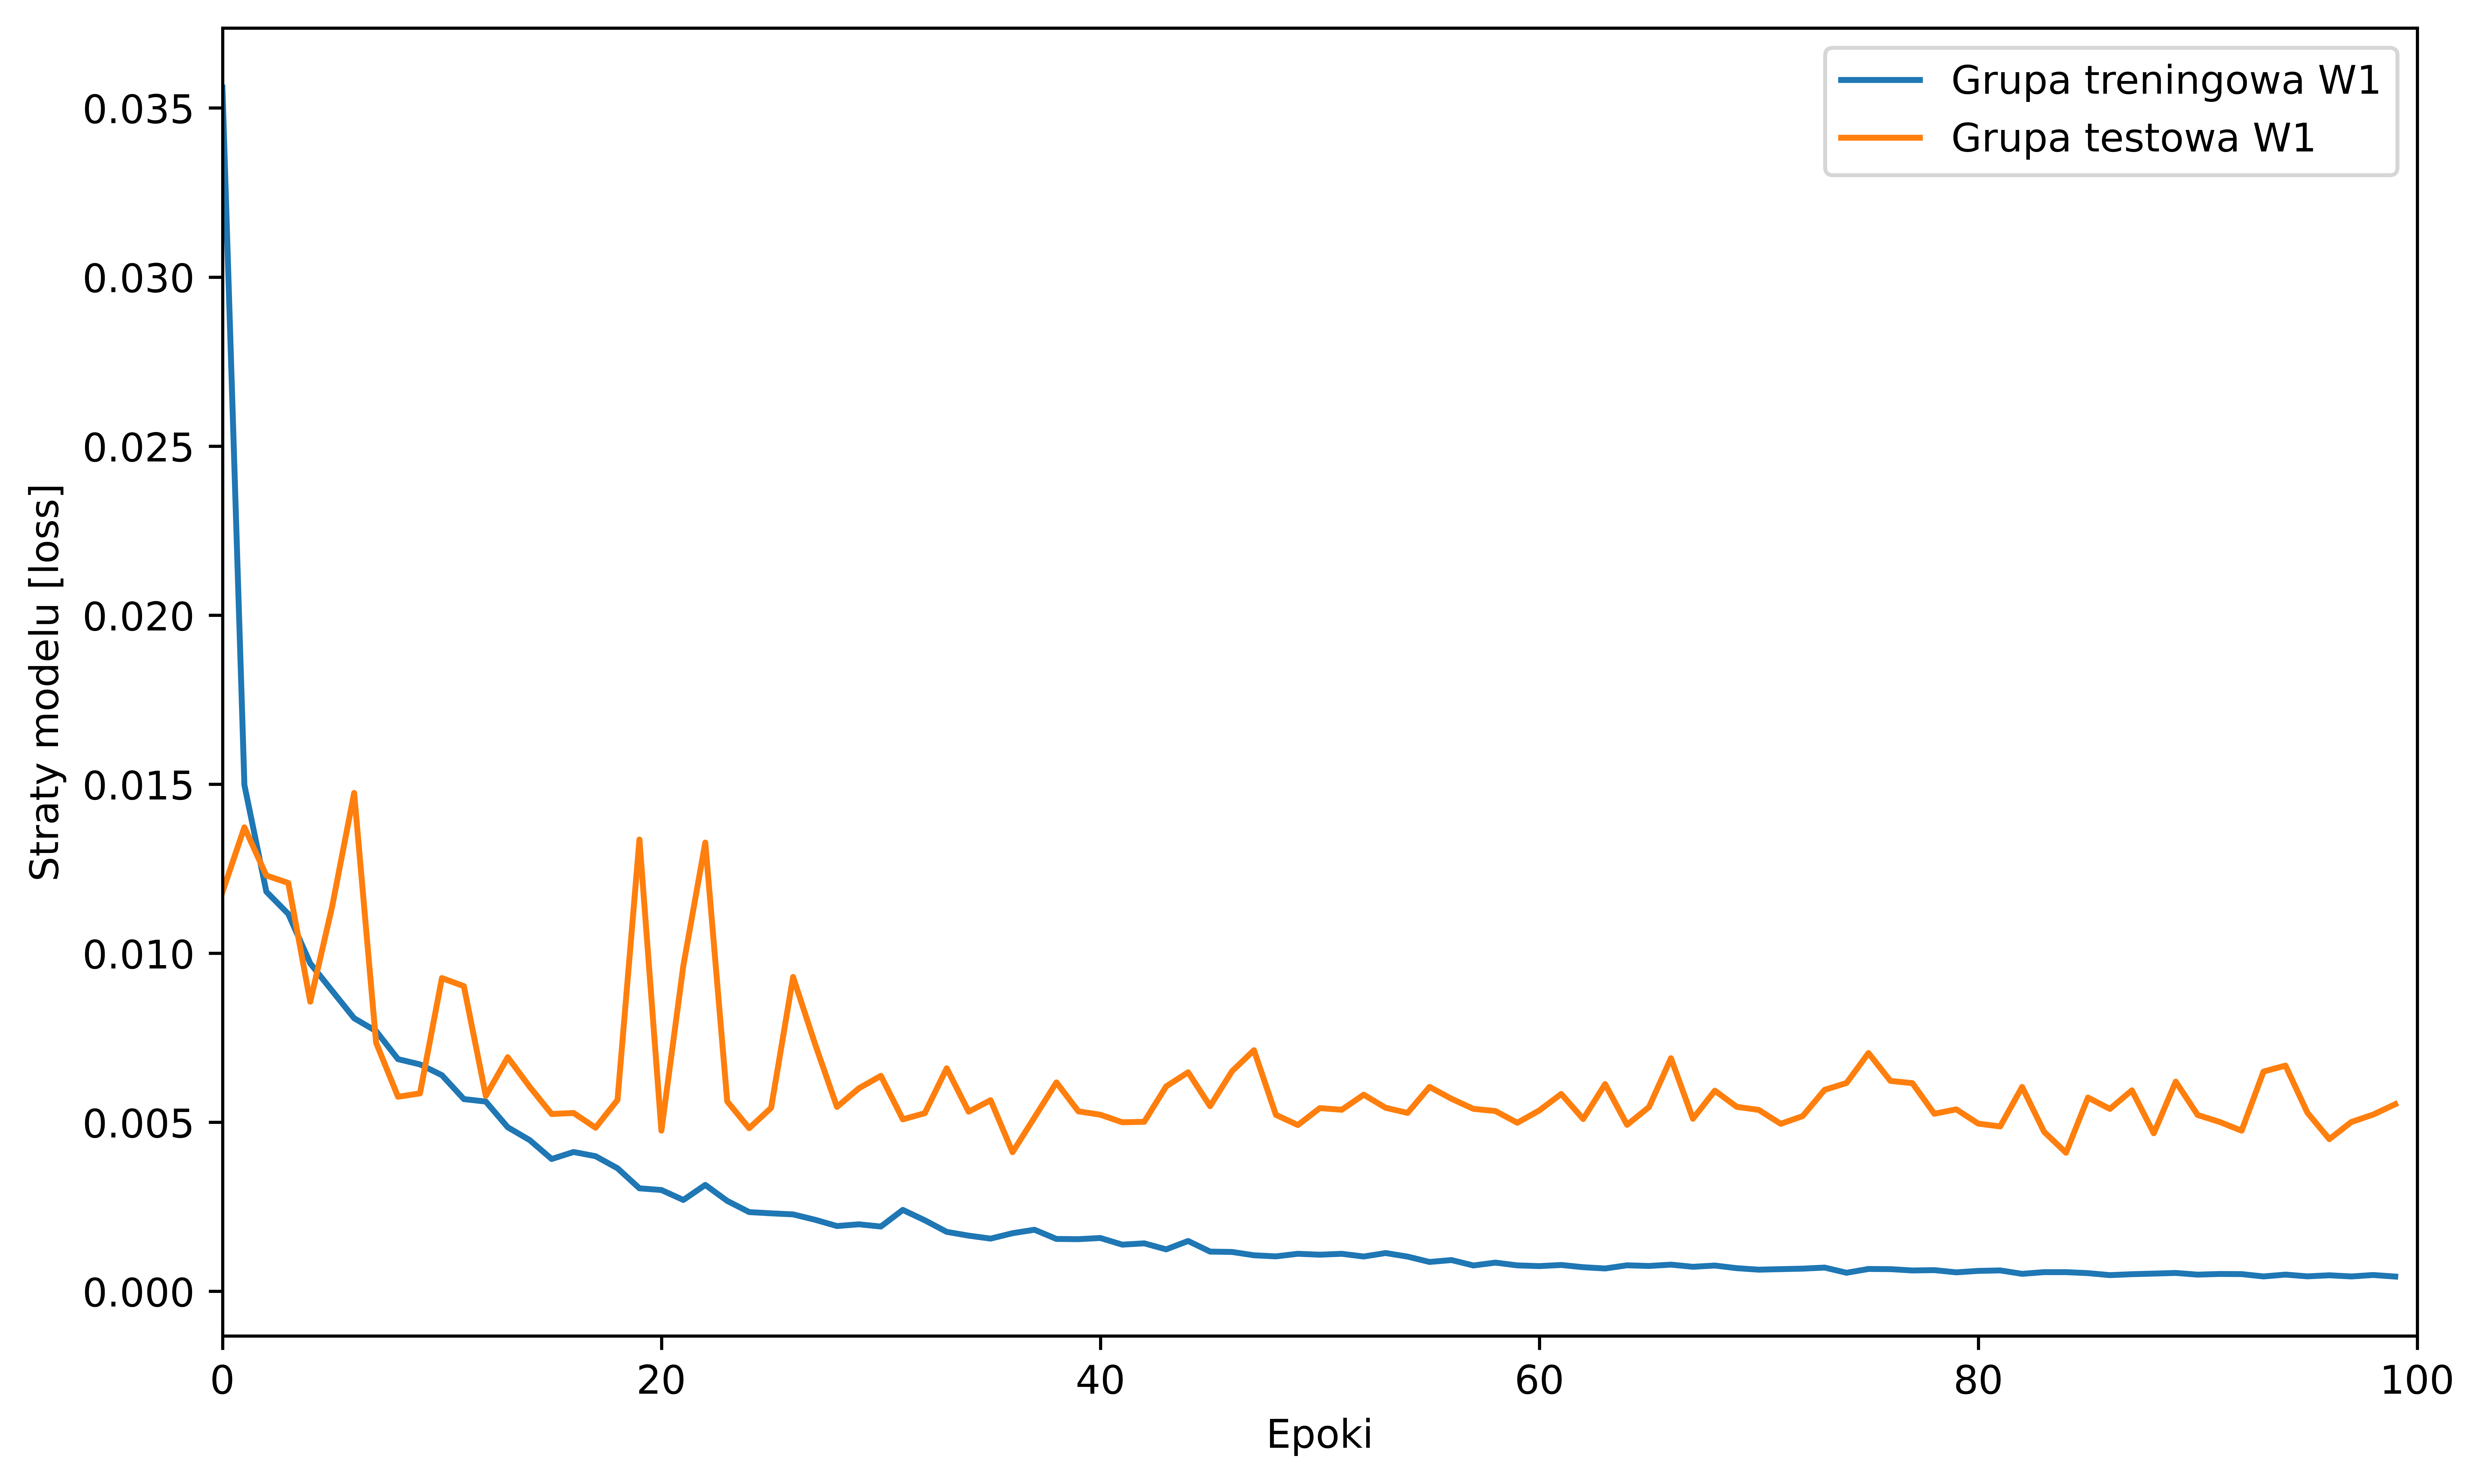

In [21]:
#testy

mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
mape_metric.update_state(y_test_rescaled, predictions_rescaled)
mape_result = mape_metric.result().numpy()
errormeanabs = meanabs(y_test_rescaled, predictions_rescaled)
errormse = mse(y_test_rescaled, predictions_rescaled)
errorrmse = rmse(y_test_rescaled, predictions_rescaled)
errorrmspe = rmspe(y_test_rescaled, predictions_rescaled)
errorstde = stde(y_test_rescaled, predictions_rescaled)
results = {'LSTM': [errormeanabs, errormse, errorrmse, errorrmspe, errorstde, mape_result],
 }
# results = {
#     'Metric': ['Mean Absolute', 'MSE', 'RMSE', 'Root Mean Squared Percentage RMSPE', 'STDE'],
#     'Value': [errormeanabs, errormse, errorrmse, errorrmspe, errorstde]}

#print("Mean Absolute Percentage Error:", mape_result)

# blad_df = pd.DataFrame(results, index=['Średni błąd bezwzględny (MAE)', 'Średni błąd kwadratowy (MSE)', 'Pierwiastek błędu średniokwadratowego (RMSE)', 
#              'Pierwiastek średniego błędu procentowego (RMSPE)', 'Standard Error(STDE)', 'MAPE'])
# filename_excel = f'time_steps={time_steps}_liczb_neuronow={liczb_neuronow}_epok={l_epok}_obser={l_obser}.xlsx'
# blad_filepath = os.path.join(result_folder, 'bledy_'+ filename_excel)
# blad_df.to_excel(blad_filepath, index=False)


# Wykres realnych cen i prognozowanych
plt.figure(dpi = 1000, figsize=(10, 6))
plt.plot(y_test_rescaled, label='Ceny energii ')
plt.plot(predictions_rescaled, label='Prognoza LSTM optymalny' )
plt.xlabel('Godzina (iteracyjna)')
plt.ylabel('Cena energii [zł/kWh]')
plt.legend()
plt.xlim(0,)

############## wykresy loss
plt.figure(dpi = 1000, figsize=(10, 6))
plt.plot(model_tworz.history['loss'])
plt.plot(model_tworz.history['val_loss'])
plt.ylabel('Straty modelu [loss]')
plt.xlabel('Epoki')
plt.legend(['Grupa treningowa W%i' %lp_wariant, 'Grupa testowa W%i' %lp_wariant], loc='upper right')
plt.xlim(0,l_epok)


In [ ]:
weights = pd.DataFrame(weights)
print(weights)
wagi_calosc = os.path.join(result_folder, 'wszystkie wagi_'+ filename_excel)
weights.to_excel(wagi_calosc)

Wyniki modelu ####################################

tworzenie wariantów
*   time steps = 24, 48, 72, 96
*   liczba neuronów = 32, 64, 128, 256, 512, 1024
*   liczba epok = 50, 100, 200, 500, 1000, 2000
*   batch size = 64, 128, 256

bazowy
*   time steps = 24
*   liczba neuronów =64
*   liczba epok =500
*   batch size = 64

# iteracje dla neuronów

In [ ]:
lp_wariant = 0

time_steps_list = [6, 12, 24, 48, 72, 96]
#num_neurons_list = [32, 64, 128, 256, 512]
#num_epochs_list = [50, 100, 200, 500, 1000, 2000]
#batch_size_list = [4, 8, 16, 32, 64]


#time_steps = 24                  # z iu bierze do prognozy
liczb_neuronow = 64
l_epok = 500                    # ile iteracji modelu
l_obser= 32                     # jako batch size - liczba obserwacji wchodzącej w jednej iteracji do sieci neuronowej - czyli co 64 obserwacje zmienia wagi
optymalizator = 'adam'          # rodzaj optymalizacji modelu - możliwe
rodz_aktywacji = 'tanh'         # rodzaj aktywacji LSTM             relu        tanh 

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps+1):
            X_seq.append(X[i:i+time_steps])
            y_seq.append(y[i+time_steps-1])  # Używamy ostatniej wartości z sekwencji jako target
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

results = []
for time_steps in time_steps_list:
    # Przygotowanie danych w formie sekwencji dla modelu LSTM

    lp_wariant=lp_wariant+1
    print(lp_wariant)
    # Utworzenie modelu LSTM
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.LSTM(units=liczb_neuronow, input_shape=(time_steps, X_train_seq.shape[2]), activation=rodz_aktywacji)) # , return_sequences=True
    # model.add(tf.keras.layers.LSTM(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(optimizer=optymalizator, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    # Trening modelu
    model_tworzW1 = model.fit(X_train_seq, y_train_seq, epochs=l_epok, batch_size=l_obser, validation_split=0.2)

    # Prognozowanie na zbiorze testowym
    predictionsW1 = model.predict(X_test_seq)

    # Skalowanie spowrotem do pierwotnej skali
    predictionsW1_rescaled = scaler_y.inverse_transform(predictionsW1)
    y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

    ################# testy

    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_metric.update_state(y_test_rescaled, predictionsW1_rescaled)
    mape_result = mape_metric.result().numpy()
    errormeanabs = meanabs(y_test_rescaled, predictionsW1_rescaled)
    errormse = mse(y_test_rescaled, predictionsW1_rescaled)
    errorrmse = rmse(y_test_rescaled, predictionsW1_rescaled)
    errorrmspe = rmspe(y_test_rescaled, predictionsW1_rescaled)
    errorstde = stde(y_test_rescaled, predictionsW1_rescaled)
    results = {'LSTM{lp_wariant}': [errormeanabs, errormse, errorrmse, errorrmspe, errorstde, mape_result],
    }
    # results = {
    #     'Metric': ['Mean Absolute', 'MSE', 'RMSE', 'Root Mean Squared Percentage RMSPE', 'STDE'],
    #     'Value': [errormeanabs, errormse, errorrmse, errorrmspe, errorstde]}

    #print("Mean Absolute Percentage Error:", mape_result)

    blad_df = pd.DataFrame(results, index=['Średni błąd bezwzględny (MAE)', 'Średni błąd kwadratowy (MSE)', 'Pierwiastek błędu średniokwadratowego (RMSE)', 
                'Pierwiastek średniego błędu procentowego (RMSPE)', 'Standard Error(STDE)', 'MAPE'])
    filename_excel = f'time_steps={time_steps}_liczb_neuronow={liczb_neuronow}_epok={l_epok}_obser={l_obser}.xlsx'
    blad_filepath = os.path.join(result_folder, 'bledy_'+ filename_excel)
    blad_df.to_excel(blad_filepath, index=False)

    ########### Wykres realnych cen i prognozowanych
    plt.figure(dpi = 1000, figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Ceny energii ')
    plt.plot(predictionsW1_rescaled, label='Prognoza LSTM W%i' %lp_wariant)
    plt.xlabel('Godzina (iteracyjna)')
    plt.ylabel('Cena energii [zł/kWh]')
    plt.legend()
    nazw_wykresow = f'time_steps={time_steps}_liczb_neuronow={liczb_neuronow}_epok={l_epok}_obser={l_obser}.png'
    plot_filepath = os.path.join(result_folder, 'wykres_'+ nazw_wykresow)
    plt.savefig(plot_filepath)  # Zapisz wykres jako plik PNG
    plt.close()

    ############## wykresy loss
    plt.figure(dpi = 1000, figsize=(10, 6))
    plt.plot(model_tworzW1.history['loss'])
    plt.plot(model_tworzW1.history['val_loss'])
    plt.ylabel('Straty modelu [loss]')
    plt.xlabel('Epoki')
    plt.legend(['Grupa treningowa W%i' %lp_wariant, 'Grupa testowa W%i' %lp_wariant], loc='upper right')
 
    plot_filepath = os.path.join(result_folder, 'wykres_loss'+ nazw_wykresow)
    plt.savefig(plot_filepath)  # Zapisz wykres jako plik PNG
    plt.close()

    ############## wykresy loss ostatnie 100
    plt.figure(dpi = 1000, figsize=(10, 6))
    plt.plot(model_tworzW1.history['loss'])
    plt.plot(model_tworzW1.history['val_loss'])
    plt.xlim(10,l_epok)
    plt.ylabel('Straty modelu [loss]')
    plt.xlabel('Epoki')
    plt.legend(['Grupa treningowa W%i' %lp_wariant, 'Grupa testowa W%i' %lp_wariant], loc='upper right')
    plot_filepath = os.path.join(result_folder, 'wykres_loss_poza_pierwszym10 '+ nazw_wykresow)
    plt.savefig(plot_filepath)  # Zapisz wykres jako plik PNG
    plt.close()

    ############## Pobranie wag warstwy wyjściowej
    output_layer = model.layers[-1]
    weights = output_layer.get_weights()[0]
    feature_importances = weights[:-1]  # Pomijamy wagę dla biasu

    wagi_egzog=[]

    for i, feature in enumerate(selected_features[1:]):  # Pomijamy cenę energii
        wagi_egzog.append(feature_importances[i][0])
        #print(f'Zmienna: {feature}, Wpływ: {feature_importances[i][0]}')
        #print (feature_importances[i][0])
    wagi_egzog=pd.DataFrame(wagi_egzog)

    wagi_egzog.to_csv(f'wagi_time_steps={time_steps}_liczb_neuronow={liczb_neuronow}_epok={l_epok}_obser={l_obser}.csv', index=False)

